##### –ò–º–ø–æ—Ä—Ç –¥–∞—Ç–∞ —Å–µ—Ç–∞

In [1]:
import numpy as np
import pandas as pd

import random
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import chi2_contingency
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, KFold, RandomizedSearchCV

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Input
DATA_TRAIN_PATH = "course_project_train.csv"
DATA_TEST_PATH="course_project_test.csv"

In [4]:
# output
DATA_PATH_PREP = "course_project_train_prep.csv"
DATA_TEST_PATH_PREP="course_project_test_prep.csv"
FINAL_PATH = 'DSizov_predictions.csv'
# Scaler
SCALER_FILE_PATH = 'scaler.pkl'

In [5]:
# –§—É–Ω–∫—Ü–∏—è –∑–∞–º–µ–Ω—è–µ—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –º–µ–¥–∏–∞–Ω–Ω—ã–µ
def mediana(data,col):
    data.loc[data[col].isna()==True,col]=data[col].median()

In [6]:
# –§—É–Ω–∫—Ü–∏—è –∑–∞–º–µ–Ω—è–µ—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –º–æ–¥—É
def moda(df, dt, col):
    col_mode=df[col].mode()[0]
    df.loc[df[col].isna()==True,col]=col_mode
    dt.loc[dt[col].isna()==True,col]=col_mode

In [7]:
# –§—É–Ω–∫—Ü–∏—è –≤—ã–≤–æ–¥–∏—Ç –Ω–∞–∑–≤–∞–Ω–∏–µ –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π –¥–ª—è –¥–∞–Ω–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π 
def checking(data,col):
    a=0
    for i in data[col].unique():
        if type(i)==np.nan:
            _count=data[col].isna().sum()
            print(f'{i} = {_count}')
        else:
            _count=data.loc[data[col]==i, col].count()
            print(f'{i} = {_count}')
        a+=_count
    print('–ü—Ä–æ–≤–µ—Ä–æ—á–Ω–∞—è —Å—É–º–º–∞',a)

In [8]:
# –î–∞–Ω–Ω—ã–π –∞–ª–≥–æ—Ä–∏—Ç–º –ø—Ä–∏—Å–≤–∞–∏–≤–∞–µ—Ç —Å—Ç—Ä–æ–∫–æ–≤—ã–º –∑–Ω–∞—á–µ–Ω–∏—è–º Years in current job 
# —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è 
def yearssmap(data):
    data['Years in current job']=data['Years in current job'].map({'10+ years':10,
                                    '8 years':8,
                                    '6 years':6,
                                    '7 years':7,
                                    '5 years':5,
                                    '1 year':1,
                                    '< 1 year':0,
                                    '4 years':4,
                                    '3 years':3,
                                    '2 years':2,
                                    '9 years':9
                                    }).astype(np.int64)

In [9]:
# –§—É–Ω–∫—Ü–∏—è –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç —Å—Ç—Ä–æ–∫–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ —á–∏—Å–ª–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é, –ø—Ä–∏—Å–≤–∞–∏–≤–∞—è –µ–π —á–∏—Å–ª–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –æ—Ç 0 —Å —à–∞–≥–æ–º 1
def converting(data, col, pattern=None, _type=np.int64):
    if pattern==None:
        _dict={}
        _iter=0
        for names in data[col].unique():
            _dict[names]=_iter
            _iter+=1
        return data[col].map(_dict).astype(_type), _dict
    else:
        _dict=pattern
        return data[col].map(_dict).astype(_type)

In [10]:
# –ó–∞–º–µ–Ω–∞ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π
# –∏–∑ —Ä–µ–≥—É–ª—è—Ä–Ω—ã—Ö –∫–æ–ª–æ–Ω–æ–∫ –≤–æ–∑–º–æ–∂–Ω–æ —É–±—Ä–∞—Ç—å 'Current Loan Amount', –µ—Å–ª–∏ –¥–∞–Ω–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫ —Ç–∞–∫–∂–µ –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è —á–∏—Å—Ç–∏—Ç—å
def regres(df, y, reg_model = None, scaler = None, reg_cols = ['Home Ownership', 
                              'Tax Liens', 
                              'Number of Open Accounts', 
                              'Years of Credit History',
                              'Maximum Open Credit',
                              'Number of Credit Problems',
                              'Purpose', 'Term',
#                               'Current Loan Amount',
                              'Current Credit Balance',
                              'Monthly Debt',
#                               'Credit Default'
                                         ]):
    if reg_model == None:
        db = df.copy()
        db_test = db.loc[db[y].isna() == False]
        db_tofill = db.loc[db[y].isna() == True]
        
        X_train = db_test[reg_cols]
        X_test = db_tofill[reg_cols]
        y_train = db_test[y]
        
        scaler = MinMaxScaler()
        
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.transform(X_test)
        
        regression = LinearRegression()
        reg = regression.fit(X_train_scale, y_train)
        y_pred = reg.predict(X_test_scale)
        db.loc[db[y].isna() == True, y] = y_pred
        df = db.copy()
        return df, reg, scaler
    
# –ï—Å–ª–∏ —É –Ω–∞—Å —É–∂–µ –±—ã–ª–∞ –æ–±—É—á–µ–Ω–∞ –º–æ–¥–µ–ª—å, —Ç–æ –º—ã –±–µ—Ä–µ–º –∑–∞ –æ—Å–Ω–æ–≤—É –µ–µ
    else:
        db = df.copy()
        db_tofill = db.loc[db[y].isna() == True]
        X_test = db_tofill[reg_cols]
        
        X_test_scale = scaler.transform(X_test)
        
        y_pred = reg_model.predict(X_test_scale)
        db.loc[db[y].isna() == True, y] = y_pred
        df = db.copy()
        return df

##### –û–±–∑–æ—Ä –æ–±—É—á–∞—é—â–µ–≥–æ –¥–∞—Ç–∞ —Å–µ—Ç–∞

**–û–ø–∏—Å–∞–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞**

* **Home Ownership** - –¥–æ–º–æ–≤–ª–∞–¥–µ–Ω–∏–µ
* **Annual Income** - –≥–æ–¥–æ–≤–æ–π –¥–æ—Ö–æ–¥
* **Years in current job** - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–µ—Ç –Ω–∞ —Ç–µ–∫—É—â–µ–º –º–µ—Å—Ç–µ —Ä–∞–±–æ—Ç—ã
* **Tax Liens** - –Ω–∞–ª–æ–≥–æ–≤—ã–µ –æ–±—Ä–µ–º–µ–Ω–µ–Ω–∏—è
* **Number of Open Accounts** - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∫—Ä—ã—Ç—ã—Ö —Å—á–µ—Ç–æ–≤
* **Years of Credit History** - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–µ—Ç –∫—Ä–µ–¥–∏—Ç–Ω–æ–π –∏—Å—Ç–æ—Ä–∏–∏
* **Maximum Open Credit** - –Ω–∞–∏–±–æ–ª—å—à–∏–π –æ—Ç–∫—Ä—ã—Ç—ã–π –∫—Ä–µ–¥–∏—Ç
* **Number of Credit Problems** - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–±–ª–µ–º —Å –∫—Ä–µ–¥–∏—Ç–æ–º
* **Months since last delinquent** - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–µ—Å—è—Ü–µ–≤ —Å –ø–æ—Å–ª–µ–¥–Ω–µ–π –ø—Ä–æ—Å—Ä–æ—á–∫–∏ –ø–ª–∞—Ç–µ–∂–∞
* **Bankruptcies** - –±–∞–Ω–∫—Ä–æ—Ç—Å—Ç–≤–∞
* **Purpose** - —Ü–µ–ª—å –∫—Ä–µ–¥–∏—Ç–∞
* **Term** - —Å—Ä–æ–∫ –∫—Ä–µ–¥–∏—Ç–∞
* **Current Loan Amount** - —Ç–µ–∫—É—â–∞—è —Å—É–º–º–∞ –∫—Ä–µ–¥–∏—Ç–∞
* **Current Credit Balance** - —Ç–µ–∫—É—â–∏–π –∫—Ä–µ–¥–∏—Ç–Ω—ã–π –±–∞–ª–∞–Ω—Å
* **Monthly Debt** - –µ–∂–µ–º–µ—Å—è—á–Ω—ã–π –¥–æ–ª–≥
* **Credit Default** - —Ñ–∞–∫—Ç –Ω–µ–≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∫—Ä–µ–¥–∏—Ç–Ω—ã—Ö –æ–±—è–∑–∞—Ç–µ–ª—å—Å—Ç–≤ (0 - –ø–æ–≥–∞—à–µ–Ω –≤–æ–≤—Ä–µ–º—è, 1 - –ø—Ä–æ—Å—Ä–æ—á–∫–∞)

In [11]:
df=pd.read_csv(DATA_TRAIN_PATH)
dt=pd.read_csv(DATA_TEST_PATH)

In [12]:
display(df.head(5), df.shape)
display(dt.head(5), dt.shape)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

(7500, 17)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

(2500, 16)

#### –ü—Ä–æ–≤–µ—Ä—è–µ–º –Ω–∞ –Ω–∞–ª–∏—á–∏–µ –ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π

In [13]:
display(len(df)-df.count())
display(len(dt)-dt.count())

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score –∏–º–µ—é—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∫–∞–∫ –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ —Ç–∞–∫ –∏ –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π

### –ü–æ—Ä—è–¥–æ–∫ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –∫–∞–∫ –æ–±—É—á–∞—é—â–µ–≥–æ —Ç–∞–∫ –∏ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞ —Å–µ—Ç–∞
- –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–∞  'Years in current job' –∑–∞–º–µ–Ω—è–µ–º –º–æ–¥–æ–π. –ü–µ—Ä–µ–≤–æ–¥–∏–º –∑–Ω–∞—á–µ–Ω–∏ –∏–∑ —Å—Ç—Ä–æ–∫–æ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –≤ —á–∏—Å–ª–æ–≤—É—é.

- –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–∞ 'Bankruptcies' –∑–∞–º–µ–Ω—è–µ–º –º–æ–¥–æ–π.

- –î–ª—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤  'Years in current job', 'Home Ownership', 'Purpose',   'Term' –∏–∑–º–µ–Ω—è–µ–º —Ç–∏–ø –¥–∞–Ω–Ω—ã—Ö - —Å—Ç—Ä–æ–∫–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –º–µ–Ω—è–µ–º –Ω–∞ —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω—ã–µ.
  
- –û—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–∞ 'Months since last delinquent' –∑–∞–º–µ–Ω—è–µ–º –Ω–∞ '0'.
  
- –í–≤–æ–¥–∏–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é 'Delinquent evidence', –æ—Ç—Ä–∞–∂–∞—é—â—É—é –ª–∏–±–æ –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ –ø–æ –≤—ã–ø–ª–∞—Ç–µ '0' –ª–∏–±–æ –Ω–∞–ª–∏—á–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ '1'.

- –î–∞—Ç–∞—Å–µ—Ç—ã —á–∏—Å—Ç—è—Ç—Å—è –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤.

- –û—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ —á–∏—Å–ª–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è Annual Income –∏ Credit Score –∑–∞–º–µ–Ω—è—é—Ç—Å—è –º–µ–¥–∏–∞–Ω–æ–π.


### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö

#### –û–±—Ä–∞–±–∞—Ç—ã–≤–µ–º –ø—Ä–∏–∑–Ω–∞–∫ 'Years in current job' 

In [14]:
# –ó–∞–º–µ–Ω—è–µ–º –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –º–æ–¥–æ–π
moda(df,dt,'Years in current job')

# –ü–µ—Ä–µ–≤–æ–¥–∏–º –∑–Ω–∞—á–µ–Ω–∏—è –∏–∑ –∏–∑ —Å—Ç—Ä–æ–∫–∏ –≤ —á–∏—Å–ª–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é
yearssmap(df)
yearssmap(dt)

#### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º 'Home Ownership' –∏–∑ —Å—Ç—Ä–æ–∫–∏ –≤ —á–∏—Å–ª–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é

In [15]:
df['Home Ownership'], HomeOwnershipPattern = converting (df, 'Home Ownership')
dt['Home Ownership'] = converting(dt, 'Home Ownership', HomeOwnershipPattern)

#### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º 'Purpose' –∏–∑ —Å—Ç—Ä–æ–∫–∏ –≤ —á–∏—Å–ª–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é

In [16]:
df['Purpose'], PurposePatern = converting(df, 'Purpose')
dt['Purpose'] = converting(dt, 'Purpose', PurposePatern)

#### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º 'Term' –∏–∑ —Å—Ç—Ä–æ–∫–∏ –≤ —á–∏—Å–ª–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é

–í –ø—Ä–∏–∑–Ω–∞–∫–µ Term –Ω–∞–±–ª—é–¥–∞–µ–º —Ç–æ–ª—å–∫–æ –¥–≤–∞ —Ç–∏–ø–∞ –∑–Ω–∞—á–µ–Ω–∏–π. –¶–µ–ª–µ—Å–æ–æ–±—Ä–∞–∑–Ω–æ –ø–µ—Ä–µ–≤–µ—Å—Ç–∏ —ç—Ç–∏ –∑–Ω–∞—á–µ–Ω–∏—è –≤ 0 –∏–ª–∏ 1

In [17]:
df['Term'], termpattern = converting(df,'Term')
dt['Term'] = converting(dt,'Term', termpattern)

#### –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫ 'Bankruptcies'
–ó–∞–º–µ–Ω—è–µ–º –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –º–æ–¥–æ–π

In [18]:
bankruptcies_mode=df['Bankruptcies'].mode()[0]
df.loc[df['Bankruptcies'].isna()==True,'Bankruptcies']=bankruptcies_mode
dt.loc[dt['Bankruptcies'].isna()==True,'Bankruptcies']=bankruptcies_mode

#### –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫ 'Months since last delinquent'

In [19]:
df.loc[df['Months since last delinquent'].isna(),:].head()

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               0       482087.0                    10        0.0   
1               0      1025487.0                    10        0.0   
2               1       751412.0                     8        0.0   
3               0       805068.0                     6        0.0   
4               2       776264.0                     8        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

   Purpose  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  \
0        0     0           99999999.0                 47386.0        7914.0   
1        0     1             264968.0                394972.0       18373.0   
2        0     0           99999999.0                308389.0       13651.0   
3        0     0             121396.0                 95855.0       11338.0   
4        0     0             125840.0                 93309.0        7180.0   

   Credit Score  Credit Default  
0         749.0               0  
1         737.0               1  
2         742.0               0  
3         694.0               0  
4         719.0               0

–ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–∞ 'Months since last delinquent' –æ–∑–Ω–∞—á–∞—é—Ç, —á—Ç–æ –ø—Ä–æ—Å—Ä–æ—á–∫–∏ –ø–ª–∞—Ç–µ–∂–∞ —É –¥–∞–Ω–æ–≥–æ –∫–ª–∏–µ–Ω—Ç–∞ –Ω–µ –±—ã–ª–æ. –í —Å–≤—è–∑–∏ —Å —á–µ–º, –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è —Ü–µ–ª–µ—Å–æ–æ–±—Ä–∞–∑–Ω–æ –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ '0' 

In [20]:
df.loc[df['Months since last delinquent'].isna(),'Months since last delinquent'] = 0
dt.loc[dt['Months since last delinquent'].isna(),'Months since last delinquent'] = 0

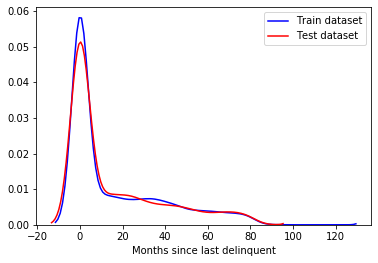

In [21]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è 
sns.distplot(df['Months since last delinquent'], color='blue', label='Train dataset', hist=False);
sns.distplot(dt['Months since last delinquent'], color='red', label='Test dataset', hist=False);

–¢–∞–∫ –∫–∞–∫ –≤–∞–∂–Ω–æ –∑–∞—Ñ–∏–∫—Å–∏—Ä–æ–≤–∞—Ç—å —Å–∞–º —Ñ–∞–∫—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –≤—ã–ø–¥–∞—Ç—ã –ø–æ –∫—Ä–µ–¥–∏—Ç—É, —Ç–æ —Ü–µ–ª–µ—Å–æ–æ–±—Ä–∞–∑–Ω–æ —Å–æ–∑–¥–∞—Ç—å –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é 'Delinquent evidence', –æ—Ç—Ä–∞–∂–∞—é—â—É—é –ª–∏–±–æ –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ –ø–æ –≤—ã–ø–ª–∞—Ç–µ **"0"** –ª–∏–±–æ –Ω–∞–ª–∏—á–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ **"1"**

In [22]:
df['Delinquent evidence']=[0 if i ==0 else 1 for i in df['Months since last delinquent']]
dt['Delinquent evidence']=[0 if i ==0 else 1 for i in dt['Months since last delinquent']]

### –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–æ–≤ –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤

#### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —á–∏—Å–ª–µ–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö


##### –ü—Ä–æ–≤–µ—Ä—è–µ–º –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è

In [23]:
display(len(df)-df.count())
print(40*'_')
display(len(dt)-dt.count())

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Delinquent evidence                0
dtype: int64

________________________________________


Home Ownership                    0
Annual Income                   513
Years in current job              0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                    513
Delinquent evidence               0
dtype: int64

#### –ü—Ä–æ–≤–µ—Ä–∏–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –≤—ã–±—Ä–æ—Å—ã

–í—ã–ø–∏—à–µ–º –∫–æ–ª–æ–Ω–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø—Ä–æ–≤–µ—Ä–∏—Ç—å –Ω–∞ –≤—ã–±—Ä–æ—Å—ã - —Ç–µ, –∫–æ—Ç–æ—Ä—ã–µ –∏–º–µ—é—Ç –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è

In [24]:
df.head()

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               0       482087.0                    10        0.0   
1               0      1025487.0                    10        0.0   
2               1       751412.0                     8        0.0   
3               0       805068.0                     6        0.0   
4               2       776264.0                     8        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           0.0           1.0   
1                        0.0                           0.0           0.0   
2                        0.0                           0.0           0.0   
3                        1.0                           0.0           1.0   
4                        1.0                           0.0           0.0   

   Purpose  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  \
0        0     0           99999999.0                 47386.0        7914.0   
1        0     1             264968.0                394972.0       18373.0   
2        0     0           99999999.0                308389.0       13651.0   
3        0     0             121396.0                 95855.0       11338.0   
4        0     0             125840.0                 93309.0        7180.0   

   Credit Score  Credit Default  Delinquent evidence  
0         749.0               0                    0  
1         737.0               1                    0  
2         742.0               0                    0  
3         694.0               0                    0  
4         719.0               0                    0

–î–ª—è –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –∑–∞ –∏—Å–∫–ª—é—á–µ–Ω–∏–µ–º 'Annual Income', 'Credit Score', 'Credit Default', —Ç–∞–∫ –∫–∞–∫ –¥–∞–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –Ω–µ –¥–ª—è –≤—Å–µ—Ö –Ω–∞–±–ª—é–¥–µ–Ω–∏–π

In [25]:
# –í—ã–¥–µ–ª–∏–º –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ, –ø–æ–ª—É-–∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
continuous=[]
semi_catogorical=[]
categorical=[]
for col in df.columns:
    if df[col].nunique()>=150:
        continuous.append(col)
    elif df[col].nunique()<150 and df[col].nunique()>=20:
        semi_catogorical.append(col)
    else:
        categorical.append(col)
        
# –£–±–∏—Ä–∞–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é 'Credit Default'
categorical.remove('Credit Default')

print(f'–ù–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ \n {continuous}')
print(30*'.')
print(f'–ü–æ–ª—É-–∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ \n {semi_catogorical}')
print(30*'.')
print(f'–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ \n {categorical}')
print(30*'.')

–ù–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ 
 ['Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
..............................
–ü–æ–ª—É-–∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ 
 ['Number of Open Accounts', 'Months since last delinquent']
..............................
–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ 
 ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Delinquent evidence']
..............................


In [26]:
# –î–∞–Ω–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –≤—ã–≤–æ–¥–∏—Ç —Ç—Ä–∏ –≥—Ä–∞—Ñ–∏–∫–∞: boxplot –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –∏ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏ –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
def plt_outlying_cases (df, dt, col_name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.tight_layout() 
    axes[0].set_title('Train Data set')
    axes[1].set_title('Test Data set')
    axes[2].set_title('Histogram')
    sns.boxplot(df[col_name],color='b', orient='v', ax=axes[0])
    sns.boxplot(dt[col_name], color='r', orient='v', ax=axes[1])
    sns.distplot(df[col_name], color='b', ax=axes[2], hist=False, label='Train')
    sns.distplot(dt[col_name], color='r', ax=axes[2], hist=False, label='Test')
    plt.show();

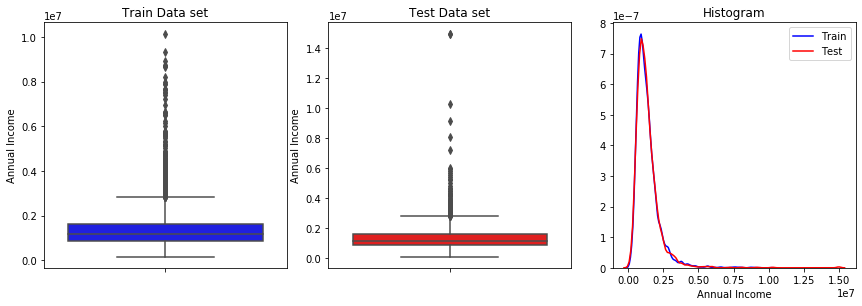

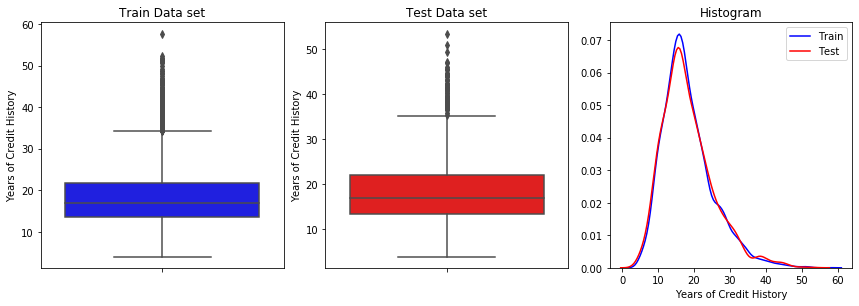

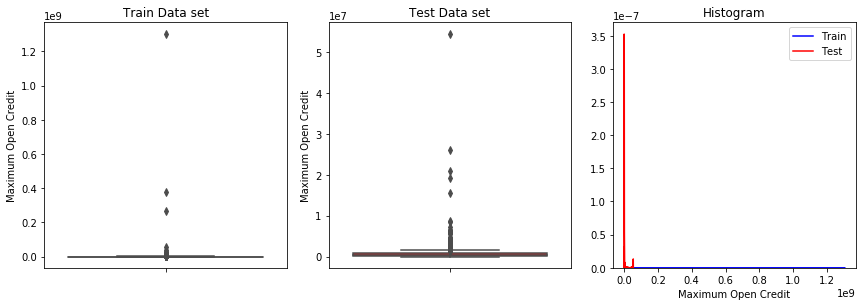

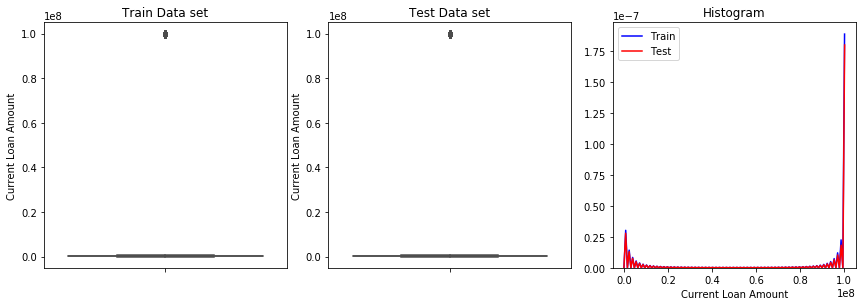

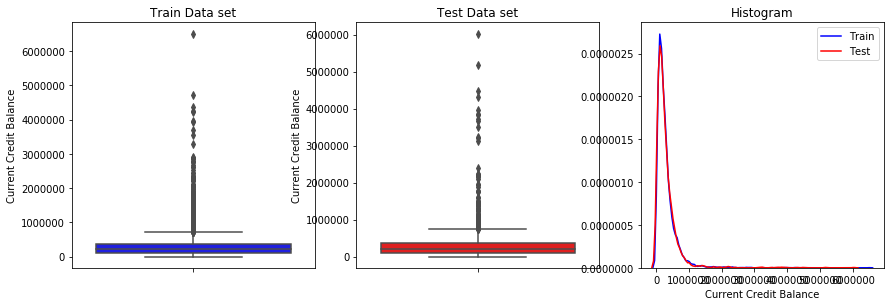

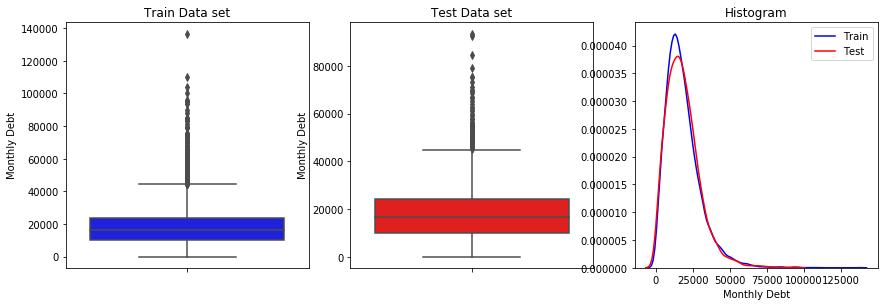

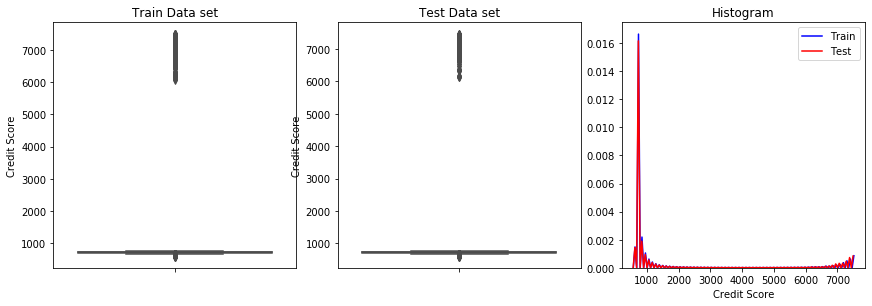

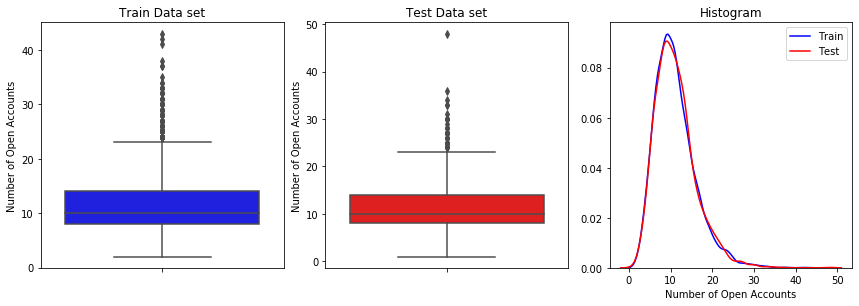

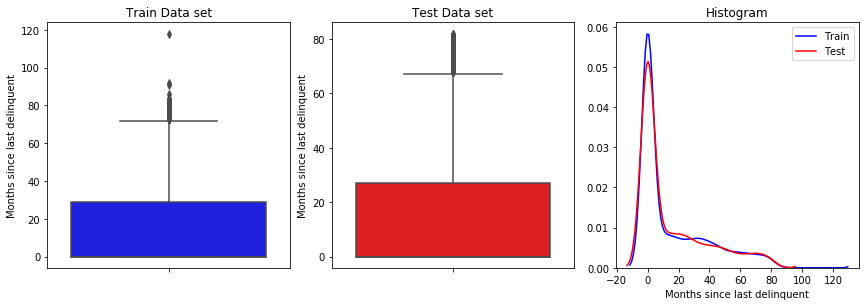

In [27]:
col_check=continuous+semi_catogorical
for name in col_check:
    plt_outlying_cases (df, dt, name)

#### –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –∏ —É–±–µ—Ä–µ–º –≤—ã–±—Ä–æ—Å—ã

–í—ã–±—Ä–æ—Å—ã:
- 'Current Loan Amount' = 99999999.0 –∑–∞–º–µ–Ω—è–µ–º –Ω–∞ –Ω–∞ None –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –¥–∞–ª–µ–µ –∏—Å–ø–æ–ª—å–∑—É—è —É–Ω–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∞–ª–≥–æ—Ä–∏—Ç–º —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –∑–∞–º–µ–Ω–∏—Ç—å –∏—Ö –Ω–∞ –∑–Ω–∞—á–µ–Ω–∏—è, –Ω–∞–π–¥–µ–Ω–Ω—ã–µ —Å –ø–æ–º–æ—â—å—é –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
- 'Maximum Open Credit' - –∑–Ω–∞—á–µ–Ω–∏—è –≤—ã—à–µ 10e7 –∏ —Ä–∞–≤–Ω—ã–µ 0 - —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏
- 'Credit Score' - –∑–Ω–∞—á–µ–Ω–∏—è –±–æ–ª—å—à–µ 2000 –¥–µ–ª–∏–º –Ω–∞ 10
- 'Current Credit Balance' - –∑–∞ –≤—ã–±—Ä–æ—Å—ã –ø—Ä–∏–Ω–∏–º–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –±–æ–ª—å—à–∏–µ 50% –æ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –∫–∞–∫ –≤—ã–±—Ä–æ—Å—ã - —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏ –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞. –î–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∑–∞–º–µ–Ω—è–µ–º –≤—ã–±—Ä–æ—Å—ã –Ω–∞ –º–µ–¥–∏–∞–Ω—É. –ù—É–ª–µ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∑–∞–º–µ–Ω—è–µ–º –Ω–∞ –º–µ–¥–∏–∞–Ω—É.
- 'Annual Income' - –∑–∞ –≥—Ä–∞–Ω–∏—Ü—É –≤—ã–±—Ä–æ—Å–æ–≤ –ø—Ä–∏–Ω–∏–º–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –±–æ–ª—å—à–µ 8000000. –î–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏ –∑–∞–º–µ–Ω—è–µ–º –Ω–∞ None, –∏ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Å –ø–æ–º–æ—â—å—é –ø–ª–≥–æ—Ä–∏—Ç–º–∞ –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
- –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —á–∏—Å–ª–µ–Ω–Ω—ã–µ –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ 'Credit Score'–± 'Annual Income', 'Current Loan Amount' –∑–∞–º–µ–Ω–∏–º –Ω–∞ –º–µ–¥–∏–∞–Ω—É.
- –ó–Ω–∞—á–µ–Ω–∏—è 'Months since last delinquent'>90 –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ —É–¥–∞–ª—è–µ–º

In [28]:
# –ó–∞–º–µ–Ω–∏–º –≤—ã–±—Ä–æ—Å—ã 'Current Loan Amount' –Ω–∞ None
df.loc[df['Current Loan Amount'] == 99999999.0,'Current Loan Amount'] = None
dt.loc[dt['Current Loan Amount'] == 99999999.0,'Current Loan Amount'] = None

In [29]:
# –í—ã–ø–∏—à–µ–º –∏–Ω–¥–µ–∫—Å—ã –≤—ã–±—Ä–æ—Å–æ–≤ 'Maximum Open Credit'
outlying_open_credit_df = df.loc[(df['Maximum Open Credit'] >= 10**7)|(df['Maximum Open Credit'] == 0)].index


# –£–¥–∞–ª–∏–º –≤—ã–±—Ä–æ—Å—ã –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏ –∑–∞–º–µ–Ω–∏–º –≤—ã–±—Ä–æ—Å—ã –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞
df.drop(index = outlying_open_credit_df, axis = 0, inplace=True)
dt.loc[(dt['Maximum Open Credit'] >= 10**7)|(dt['Maximum Open Credit'] == 0), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()

#### –ü–æ–¥—á–∏—Å—Ç–∏–º –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤ 'Credit score'

In [30]:
# –£ –Ω–∞—Å –µ—Å—Ç—å —Å–∫–æ–ø–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π 'Credit Score' –≤—ã—à–µ 2000 —Ç—ã—Å—è—á. –î–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–µ–ª–∏–º –Ω–∞ 10.
def CredSc(data):
    data.loc[data['Credit Score']>2000,'Credit Score']=data.loc[data['Credit Score']>2000,'Credit Score']/10

In [31]:
CredSc(df)
CredSc(dt)

#### –ü–æ–¥—á–∏—Å—Ç–∏–º –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤ 'Current Credit Balance'

In [32]:
# –í—ã–ø–∏—à–µ–º –∏–Ω–¥–µ–∫—Å—ã –≤—ã–±—Ä–æ—Å–æ–≤ 'Current Credit Balance'
credit_balance_max = df['Current Credit Balance'].max()*0.5
outlying_credit_balance_df = df.loc[df['Current Credit Balance'] >= credit_balance_max].index

# –£–¥–∞–ª–∏–º –≤—ã–±—Ä–æ—Å—ã –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏ –∑–∞–º–µ–Ω–∏–º –≤—ã–±—Ä–æ—Å—ã –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞
df.drop(index = outlying_credit_balance_df, axis = 0, inplace = True)
dt.loc[(dt['Current Credit Balance'] >= credit_balance_max)|(dt['Current Credit Balance']==0), 'Current Credit Balance'] = df['Current Credit Balance'].median()

#### –ü–æ–¥—á–∏—Å—Ç–∏–º –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤ 'Anual income'

In [33]:
df.loc[df['Annual Income']>8000000, 'Annual Income'] = None
dt.loc[dt['Annual Income']>8000000, 'Annual Income'] = None

#### –ü–æ–¥—á–∏—Å—Ç–∏–º –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤ 'Months since last delinquent'

In [34]:
# –í—ã–ø–∏—à–µ–º –∏–Ω–¥–µ–∫—Å—ã –≤—ã–±—Ä–æ—Å–æ–≤ 'Months since last delinquent'
outlying_delinquent_df=df.loc[df['Months since last delinquent']>90].index

# –£–¥–∞–ª–∏–º –≤—ã–±—Ä–æ—Å—ã
df.drop(index = outlying_delinquent_df, axis = 0, inplace = True)

### –ú–µ–¥–∏–∞–Ω—ã

In [35]:
mediana(df,'Credit Score')
mediana(dt,'Credit Score')
mediana(df,'Annual Income')
mediana(dt,'Annual Income')
mediana(df,'Current Loan Amount')
mediana(dt,'Current Loan Amount')

#### –õ–∏–Ω–µ–π–Ω–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è

–†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ä–∞–±–æ—Ç—ã –∞–ª–≥–æ—Ä–∏—Ç–º–∞ –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –ø–æ–∫–∞–∑–∞–ª–∏ –±–æ–ª–µ–µ –Ω–∏–∑–∫–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, —á–µ–º –∑–∞–º–µ–Ω–∞ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –º–µ–¥–∏–∞–Ω–æ–π. –í —Å–≤—è–∑–∏ —Å —á–µ–º –¥–∞–Ω–Ω—ã–π –∞–ª–≥–æ—Ä–∏—Ç–º —Ä–µ—à–µ–Ω–æ –Ω–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å

In [36]:
# len(df)-df.count()

#### –û—Ü–µ–Ω–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ —Ä–∞–∑—Ä–µ–∑–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π


–û—Ü–µ–Ω–∏–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤ —Ä–∞–∑—Ä–µ–∑–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π

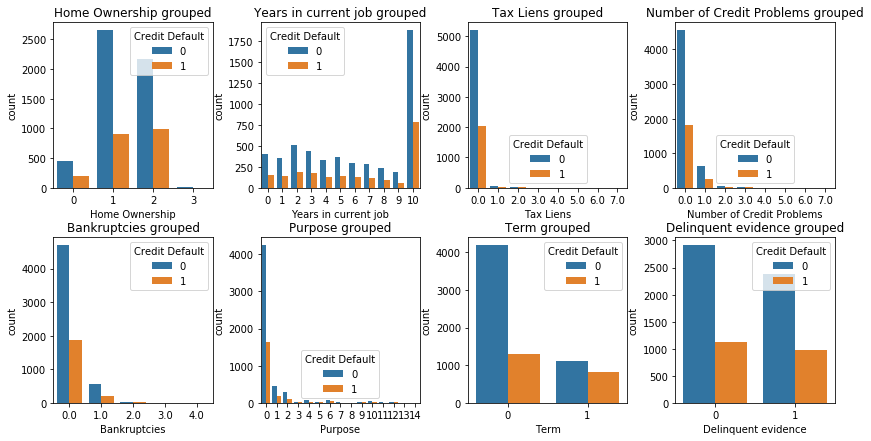

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

plt.subplots_adjust(wspace=0.3, hspace=0.3)
for en,axi in enumerate(axes.flatten()):
        
    nam=categorical[en]

    sns.countplot(x=nam, hue='Credit Default', data=df, ax=axi)
    axi.set_title(f'{nam} grouped')

plt.show();

–û–±—Ä–∞—Ç–∏–º –≤–Ω–∏–º–∞–Ω–∏–µ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫ Home ownership

#### –ê–Ω–∞–ª–∏–∑ –ø—Ä–∏–∑–Ω–∞–∫–∞ Home ownership

–ó–Ω–∞—á–µ–Ω–∏—è –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö Home ownership {'Own Home': 0, 'Home Mortgage': 1, 'Rent': 2, 'Have Mortgage': 3}

**–ì–∏–ø–æ—Ç–µ–∑–∞** 

* –ù—É–ª–µ–≤–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞: –æ–∂–∏–¥–∞–µ–º—ã–µ –∏ –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —á–∞—Å—Ç–æ—Ç—ã –¥–ª—è Home Mortgage –∏ Have Mortgage —Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω—ã 
* –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞: –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏—è –≤ —á–∞—Å—Ç–æ—Ç–∞—Ö –≤—ã—Ö–æ–¥—è—Ç –∑–∞ —Ä–∞–º–∫–∏ —Å–ª—É—á–∞–π–Ω—ã—Ö –∫–æ–ª–µ–±–∞–Ω–∏–π, —Ä–∞—Å—Ö–æ–∂–¥–µ–Ω–∏—è —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º—ã
* –ö—Ä–∏—Ç–µ—Ä–∏–π: –•–∏-–∫–≤–∞–¥—Ä–∞—Ç –ü–∏—Ä—Å–æ–Ω–∞
* –£—Ä–æ–≤–µ–Ω—å –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ $\normalsize \alpha$: 0.05
* –ö—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å: –¥–≤—É—Ö—Å—Ç–æ—Ä–æ–Ω–Ω—è—è

–î–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –¥–∞–Ω–Ω–æ–π –≥–∏–ø–æ—Ç–µ–∑—ã –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–æ–¥–∞—Ç—å –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —á–∞—Å—Ç–æ—Ç—ã –∫–∞—Ç–µ–≥–æ—Ä–∏–π 1 –∏ 3 –ø—Ä–∏–∑–Ω–∞–∫–∞ 'Home Ownership' –≤ –≤—ã–±—Ä–∞–Ω–Ω—ã–π –∫—Ä–∏—Ç–µ—Ä–∏–π, –ø–æ—Å–ª–µ —á–µ–≥–æ –æ—Ü–µ–Ω–∏—Ç—å –∑–Ω–∞—á–µ–Ω–∏–µ –¥–æ—Å—Ç–∏–≥–∞–µ–º–æ–≥–æ —É—Ä–æ–≤–Ω—è –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ p-value –∏ —Å—Ä–∞–≤–Ω–∏—Ç—å —Å –µ–≥–æ —Å –≤—ã–±—Ä–∞–Ω–Ω—ã–º –ø–æ—Ä–æ–≥–æ–º –∞–ª—å—Ñ–∞, –µ—Å–ª–∏ p-value –ø–æ–ª—É—á–∏—Ç—Å—è –±–æ–ª—å—à–µ –≤—ã–±—Ä–∞–Ω–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞, —Ç–æ –≥–∏–ø–æ—Ç–µ–∑—É –æ —Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω–Ω–æ—Å—Ç–∏ —á–∞—Å—Ç–æ—Ç –º–æ–∂–Ω–æ –Ω–µ –æ—Ç–±—Ä–∞—Å—ã–≤–∞—Ç—å.

#### –°—Ñ–æ—Ä–º–∏—Ä—É–µ–º –≤—ã–±–æ—Ä–∫—É –∏ —Ä–∞—Å—Å—á–∏—Ç–∞–µ–º –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —á–∞—Å—Ç–æ—Ç—ã


In [38]:
df_pirson=df.copy()
df_pirson['ID']=df_pirson.index
home_own_and_target_s = df_pirson.loc[df_pirson['Home Ownership'].isin([1, 3]),
                               ['ID','Home Ownership', 'Credit Default']]

table = home_own_and_target_s.pivot_table(values='ID', index='Home Ownership',
                              columns = 'Credit Default', aggfunc='count')
table

Credit Default     0    1
Home Ownership           
1               2656  911
3                  9    2

–ü—Ä–æ–≤–µ—Ä–∏–º –Ω–∞—à—É –≥–∏–ø–æ—Ç–µ–∑—É –∏—Å–ø–æ–ª—å–∑—É—è –∫—Ä–∏—Ç–µ—Ä–∏–π –•–∏-–∫–≤–∞–¥—Ä–∞—Ç –ü–∏—Ä—Å–æ–Ω–∞


In [39]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
round(p,9)

0.576229135

–í —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –∫—Ä–∏—Ç–µ—Ä–∏–µ–º –•–∏-–∫–≤–∞–¥—Ä–∞—Ç –ü–∏—Ä—Å–æ–Ω–∞ —É—Ä–æ–≤–µ–Ω—å –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ 0.58, —á—Ç–æ  –≤—ã—à–µ —É—Ä–æ–≤–Ω—è –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ ùõº: 0.05. –°–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –Ω—É–ª–µ–≤–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞ –æ —Ç–æ–º, —á—Ç–æ –æ–∂–∏–¥–∞–µ–º—ã–µ –∏ –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —á–∞—Å—Ç–æ—Ç—ã —Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω—ã –ø—Ä–∏–Ω–∏–º–∞–µ—Ç—Å—è. –û–±—ä–µ–¥–µ–Ω–∏–º 'Home Ownership' = 1 –∏ 'Home Ownership' = 3

In [40]:
df.loc[df['Home Ownership']==3,'Home Ownership'] = 1
dt.loc[dt['Home Ownership']==3,'Home Ownership'] = 1

### –ê–Ω–∞–ª–∏–∑ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤–æ–≥–æ –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞

#### –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Å –ø–æ–º–æ—â—å—é –∫—Ä–∏—Ç–µ—Ä–∏—è –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫–∞

In [41]:
for i in continuous:
    print(f'p-value –¥–ª—è {i}: {shapiro(df[i])[1]}')

p-value –¥–ª—è Annual Income: 0.0
p-value –¥–ª—è Years of Credit History: 0.0
p-value –¥–ª—è Maximum Open Credit: 0.0
p-value –¥–ª—è Current Loan Amount: 0.0
p-value –¥–ª—è Current Credit Balance: 0.0
p-value –¥–ª—è Monthly Debt: 0.0
p-value –¥–ª—è Credit Score: 0.0


p_value –≤–æ –≤—Å–µ—Ö —Å–ª—É—á–∞—è—Ö —Ä–∞–≤–Ω—ã –∏–ª–∏ –±–ª–∏–∑–∫–∏ 0, —Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–µ –∏–º–µ—é—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è. –î–ª—è –ø—Ä–∏–≤–µ–¥–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∫ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–º—É –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç—Å—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∞–ª–≥–æ—Ä–∏—Ç–º –±–æ–∫—Å–∞-–∫–æ–∫—Å–∞

#### –ù–æ—Ä–º–∞–ª–∏–∑—É–µ–º –¥–∞–Ω–Ω—ã–µ

–í–∏–∑—É–∞–ª—å–Ω–æ –ø—Ä–æ–≤–µ—Ä–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å –ø–æ–º–æ—â—å—é QQ-–≥—Ä–∞—Ñ–∏–∫–∞

In [42]:
to_normalize=['Current Credit Balance','Monthly Debt','Annual Income','Maximum Open Credit']

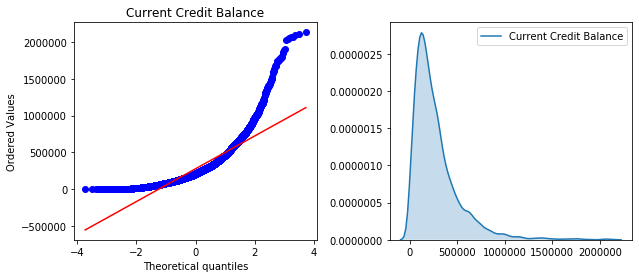

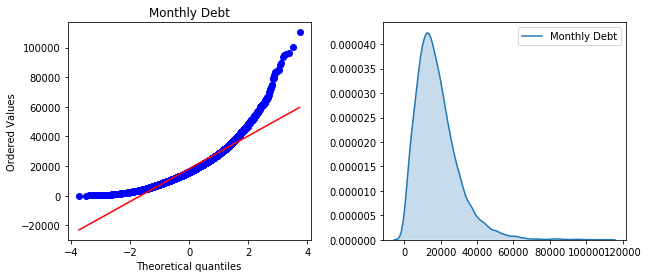

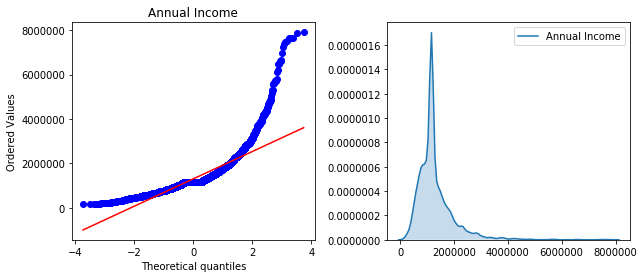

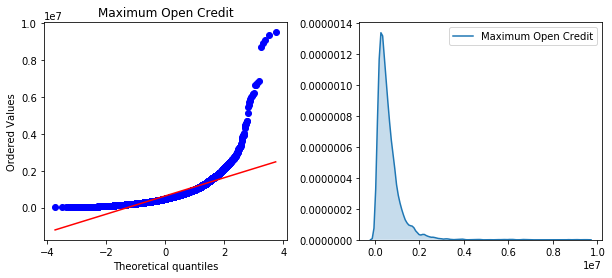

In [43]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(df[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(df[col_name], shade=True, label=col_name, ax=ax2)

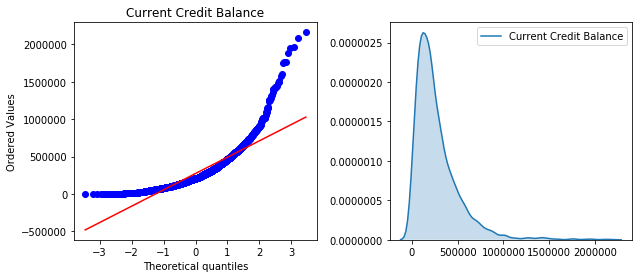

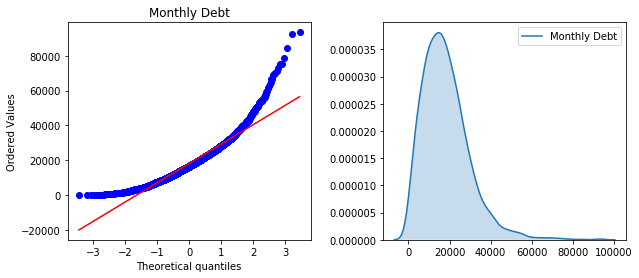

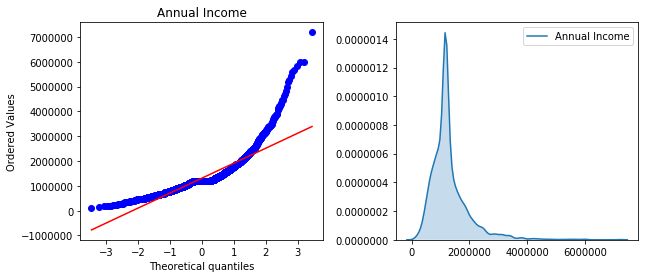

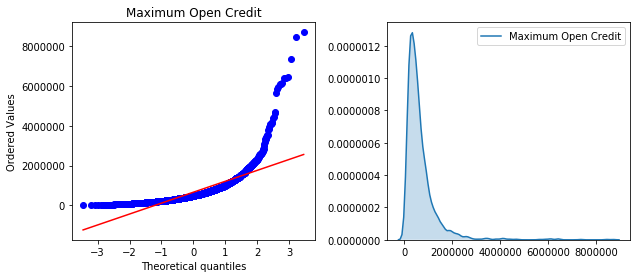

In [44]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(dt[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(dt[col_name], shade=True, label=col_name, ax=ax2)

–û—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ "—Ö–≤–æ—Å—Ç–æ–≤" —Ç–∞–∫–∂–µ —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É–µ—Ç –æ–± –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–∏ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è 

#### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞–Ω–Ω—ã–µ —Å –ø–æ–º–æ—â—å—é –∞–ª–≥–æ—Ä–∏—Ç–º–∞ –ë–æ–∫—Å–∞ –ö–æ–∫—Å–∞

In [45]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
df['Current Credit Balance'], lmbda_df1 = boxcox(df['Current Credit Balance'])
df['Monthly Debt'], lmbda_df2 = boxcox(df['Monthly Debt'])
df['Annual Income'], lmbda_df3 = boxcox(df['Annual Income'])
df['Maximum Open Credit'], lmbda_df4 = boxcox(df['Maximum Open Credit'])

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç
dt['Current Credit Balance'], lmbda_dt1 = boxcox(dt['Current Credit Balance'])
dt['Monthly Debt'], lmbda_dt2 = boxcox(dt['Monthly Debt'])
dt['Annual Income'], lmbda_dt3 = boxcox(dt['Annual Income'])
dt['Maximum Open Credit'], lmbda_dt4 = boxcox(dt['Maximum Open Credit'])

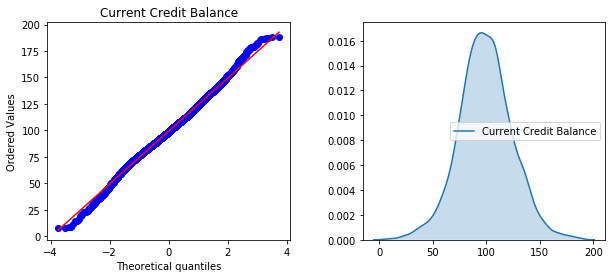

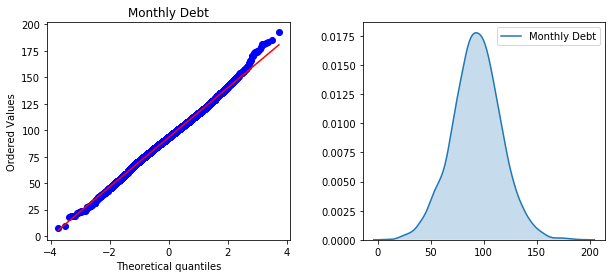

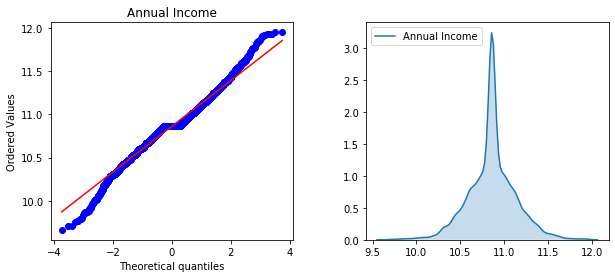

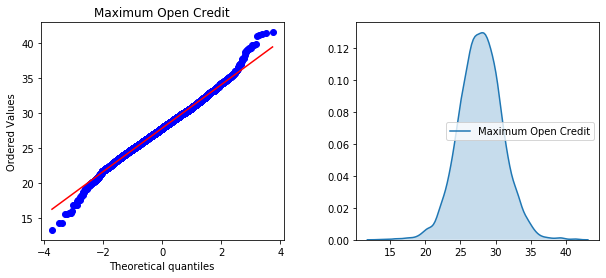

In [46]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(df[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(df[col_name], shade=True, label=col_name, ax=ax2)

–ü–æ—Å–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –ë–æ–∫—Å–∞ –ö–æ–∫—Å–∞ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏—è —Ö–≤–æ—Å—Ç–æ–≤ —Å—Ç–∞–ª–∏ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –º–µ–Ω—å—à–µ –æ—Ç –¥–∏–∞–≥–æ–Ω–∞–ª–∏. –°–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –¥–∞–Ω–Ω—ã–µ –≤—ã—Ä–æ–≤–Ω—è–ª–∏—Å—å.

### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –≤ dummie

–í—ã–±–µ—Ä–µ–º –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ, –∫–æ—Ç–æ—Ä—ã–µ —Å—Ç–æ–∏—Ç –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –≤ dummie –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ

In [47]:
for name in categorical:
    print(f'{name} \n —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ {df[name].unique()}\n —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö {df[name].dtypes}\n')

Home Ownership 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [0 1 2]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö int64

Years in current job 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [10  8  6  7  1  0  4  3  2  5  9]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö int64

Tax Liens 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [0. 3. 1. 2. 4. 6. 5. 7.]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö float64

Number of Credit Problems 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [1. 0. 3. 2. 6. 4. 5. 7.]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö float64

Bankruptcies 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [1. 0. 3. 2. 4.]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö float64

Purpose 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö int64

Term 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [0 1]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö int64

Delinquent evidence 
 —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ [0 1]
 —Ç–∏–ø –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö int64



–ò–∑ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–º–∏ –≤ —á–∏—Å—Ç–æ–º –≤–∏–¥–µ —è–≤–ª—è—é—Ç—Å—è Home Ownership, Purpose, Term, Delinquent evidence
–ü—Ä–∏ —ç—Ç–æ–º Term, Delinquent evidence –∏–º–µ—é—Ç —Ç–æ–ª—å–∫–æ –ø–æ –¥–≤–∞ –∑–Ω–∞—á–µ–Ω–∏—è. 


–ü—Ä–æ–≤–µ—Ä–∏–º –ø—Ä–∏–∑–Ω–∞–∫ Purpose - –≤—Å–µ –ª–∏ —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–∞–Ω–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –∏–∑ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ —Å–µ—Ç–∞ –∏–º–µ—é—Ç—Å—è –≤ —Ç–µ—Å—Ç–æ–≤–æ–º

In [48]:
for j in df['Purpose'].unique():
    if j not in dt['Purpose'].unique():
        print ('Purpose', j)
        print ('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π ', df.loc[df['Purpose']==j, 'Purpose'].count())

Purpose 14
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π  2


–£—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–æ, —á—Ç–æ –≤ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –ø—Ä–∏–∑–Ω–∞–∫ 'Purpose 14'. –¢–∞–∫ –∫–∞–∫ –¥–ª—è –¥–∞–Ω–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –Ω–∞–±–ª—é–¥–∞–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ –¥–≤–∞ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è, —Ç–æ —Ü–µ–ª–µ—Å–æ–æ–±—Ä–∞–∑–Ω–æ –∏—Ö —É–¥–∞–ª–∏—Ç—å

In [49]:
purpose_14_index=df.loc[df['Purpose']==14].index
df.drop(index=purpose_14_index, axis=0, inplace=True)

### –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º  –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –≤ int64 –∏ —Å–æ–∑–¥–∞–µ–º dummie –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ

In [50]:
# –†–∞–∑–æ–±—å–µ–º 'Home Ownership', 'Purpose' –Ω–∞ –¥–∞–º–º–∏ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ
dummie=['Home Ownership', 'Purpose']
df[dummie]=df[dummie].astype(np.int64)

for cat_colname in dummie:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    dt = pd.concat([dt, pd.get_dummies(dt[cat_colname], prefix=cat_colname)], axis=1)
    
# –£–¥–∞–ª–∏–º 'Home Ownership', 'Purpose'
df.drop(dummie, axis=1, inplace=True)
dt.drop(dummie, axis=1, inplace=True)

### –ú–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π


In [51]:
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Delinquent evidence',
       'Home Ownership_0', 'Home Ownership_1', 'Home Ownership_2', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5',
       'Purpose_6', 'Purpose_7', 'Purpose_8', 'Purpose_9', 'Purpose_10',
       'Purpose_11', 'Purpose_12', 'Purpose_13'],
      dtype='object')

**–í—ã—Å–æ–∫–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç—Å—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å.**
- —Å–æ–∑–¥–∞—Ç—å –Ω–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é –ø—É—Ç–µ–º –ø–µ—Ä–µ–º–Ω–æ–∂–µ–Ω–∏—è –¥–ª—è:
    - 'Maximum Open Credit' –∏ 'Current Credit Balance' 
    - 'Number of Credit Problems' –∏ 'Bankruptcies'
- —Ç–∞–∫ –∫–∞–∫ —Å–æ–∑–¥–∞–Ω –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ 'Delinquent evidence', —Ç–æ –ø—Ä–∏–∑–Ω–∞–∫ 'Months since last delinquent' —É–¥–∞–ª–∏—Ç—å


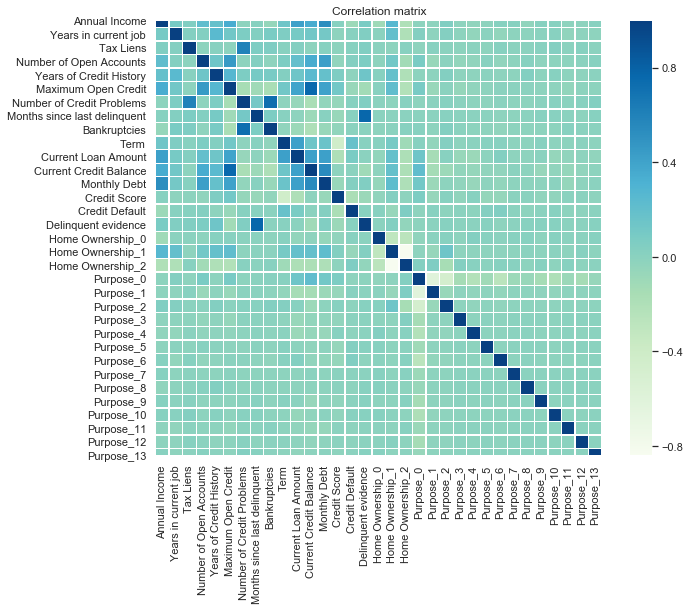

In [52]:
plt.figure(figsize = (10,8))

sns.set(font_scale=1)
sns.heatmap(df.corr().round(2), annot=False, linewidths=.3, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### –ü—Ä–æ–≤–µ—Ä–∏–º –∫–∞–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ —Å–∏–ª—å–Ω–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç –º–µ–∂–¥—É —Å–æ–±–æ–π

In [53]:
dcorr=df.corr()
CorField = []
for i in dcorr:
    for j in dcorr.index[dcorr[i] > 0.6]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))
    for j in dcorr.index[dcorr[i] < -0.5]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))

Maximum Open Credit  -->  Current Credit Balance: r^2=0.759881
Number of Credit Problems  -->  Bankruptcies: r^2=0.731382
Months since last delinquent  -->  Delinquent evidence: r^2=0.766813
Home Ownership_1  -->  Home Ownership_2: r^2=-0.840973
Purpose_0  -->  Purpose_1: r^2=-0.613505


In [54]:
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—â–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

df['Maximum_Credit_Current_balance']=df['Maximum Open Credit']*df['Current Credit Balance']
df.drop(['Maximum Open Credit', 'Current Credit Balance'], axis=1, inplace=True)

df['Cred_problem_bunkrupt']=df['Number of Credit Problems']*df['Bankruptcies']
df.drop(['Number of Credit Problems','Bankruptcies'], axis=1, inplace=True)

df.drop('Months since last delinquent', axis=1, inplace=True)

dt['Maximum_Credit_Current_balance']=dt['Maximum Open Credit']*dt['Current Credit Balance']
dt.drop(['Maximum Open Credit', 'Current Credit Balance'], axis=1, inplace=True)

dt['Cred_problem_bunkrupt']=dt['Number of Credit Problems']*dt['Bankruptcies']
dt.drop(['Number of Credit Problems','Bankruptcies'], axis=1, inplace=True)

dt.drop('Months since last delinquent', axis=1, inplace=True)

## –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π

In [55]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [56]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()
#     target_counts = pd.value_counts(df[target_name].values.flatten())

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [57]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.4, 0.6, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [58]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [59]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### –í—ã–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –∏ –≥—Ä—É–ø–ø –ø—Ä–∏–∑–Ω–∞–∫–æ–≤


In [60]:
# —É–±–∏—Ä–∞–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–º–µ–Ω–Ω—É—é –≤ TARGET_NAME
TARGET_NAME = 'Credit Default'

# –≤—ã–ø–∏—Å—ã–≤–∞–µ–º –∏–º–µ–Ω–∞  –ø—Ä–∏–∑–Ω–∞–∫–æ–≤  –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞ —Å–µ—Ç–∞
BASE_FEATURE_NAMES = df.columns[:9].tolist()

# –≤—ã–ø–∏—Å—ã–≤–∞–µ–º –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–æ–≤–æ–≥–æ –¥–∞—Ç–∞ —Å–µ—Ç–∞ —Ç–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, —á—Ç–æ –∏–∑ –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω–æ–≥–æ 
# –¥–∞—Ç–∞ —Å–µ—Ç–∞ –≤—ã–∫–∏–¥—ã–≤–∞–µ–º –∏–º–µ–Ω–∞ —Å—Ç–∞—Ä–æ–≥–æ –¥–∞—Ç–∞ —Å–µ—Ç–∞ –∏ –∏–º—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
NEW_FEATURE_NAMES = df.columns[10:].tolist()

FTR=BASE_FEATURE_NAMES+NEW_FEATURE_NAMES

### –ê–Ω–∞–ª–∏–∑ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π

#### –û–±–∑–æ—Ä —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è


In [61]:
df[TARGET_NAME].value_counts()

0    5287
1    2098
Name: Credit Default, dtype: int64

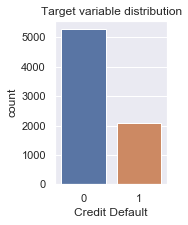

In [62]:
plt.figure(figsize=(2, 3))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

In [63]:
v0 = df[TARGET_NAME].value_counts()[0]
v1 = df[TARGET_NAME].value_counts()[1]
v1_w = (v1 / (v0 + v1)) * 100
v0_w = (v0 / (v0 + v1)) * 100
print (f'–î–æ–ª—è –∑–Ω–∞—á–µ–Ω–∏–π 0: {round(v0_w, 1)}%')
print (f'–î–æ–ª—è –∑–Ω–∞—á–µ–Ω–∏–π 1: {round(v1_w, 1)}%')
print (f'–æ—Ç–Ω–æ—à–µ–Ω–∏–µ 0/1: {round(v0_w / v1_w, 1)}')

–î–æ–ª—è –∑–Ω–∞—á–µ–Ω–∏–π 0: 71.6%
–î–æ–ª—è –∑–Ω–∞—á–µ–Ω–∏–π 1: 28.4%
–æ—Ç–Ω–æ—à–µ–Ω–∏–µ 0/1: 2.5


–£—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–æ, —á—Ç–æ –∑–Ω–∞—á–µ–Ω–∏–π '1' –≤ 2,5 —Ä–∞–∑–∞ –º–µ–Ω—å—à–µ —á–µ–º '0', —Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –ø—Ä–∏ –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –º–æ–¥–µ–ª–∏ —Ä–∞–∑–º–µ—Ä—ã –≤—ã–±–æ—Ä–æ–∫ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –±—É–¥–µ—Ç –≤—ã—Ä–æ–≤–Ω—è—Ç—å

#### –ù–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [64]:
scaler = MinMaxScaler()

df_norm=df[FTR].copy()
df_norm[FTR]=scaler.fit_transform(df_norm[FTR])
df_scale=df_norm.copy()

dt_norm=dt[FTR].copy()
dt_norm[FTR]=scaler.transform(dt_norm[FTR])
dt_scale=dt_norm.copy()

#### PCA

–ú–µ—Ç–æ–¥ –≥–ª–∞–≤–Ω—ã—Ö –∫–æ–º–ø–æ–Ω–µ–Ω—Ç —Å–Ω–∏–∑–∏–ª —Ç–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏, –ø–æ—ç—Ç–æ–º—É –æ—Ç –Ω–µ–≥–æ –ø—Ä–∏—à–ª–æ—Å—å –æ—Ç–∫–∞–∑–∞—Ç—å—Å—è

#### –†–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ train –∏ test



In [65]:
X = df_scale[FTR]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

#### –ë–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∞ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π

In [66]:
y_train.value_counts()

0    3696
1    1473
Name: Credit Default, dtype: int64

In [67]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)

df_balanced = balance_df_by_target(df_for_balancing,TARGET_NAME)    

In [68]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [69]:
y_train.value_counts()

0    3696
1    2946
Name: Credit Default, dtype: int64

##### –õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è


In [70]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3696
           1       0.62      0.45      0.52      2946

    accuracy                           0.63      6642
   macro avg       0.63      0.61      0.61      6642
weighted avg       0.63      0.63      0.62      6642

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1591
           1       0.41      0.43      0.42       625

    accuracy                           0.67      2216
   macro avg       0.59      0.60      0.59      2216
weighted avg       0.67      0.67      0.67      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1210  381
1                355  270


##### k –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π

In [71]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3696
           1       0.75      0.68      0.71      2946

    accuracy                           0.76      6642
   macro avg       0.75      0.75      0.75      6642
weighted avg       0.76      0.76      0.75      6642

TEST

              precision    recall  f1-score   support

           0       0.75      0.70      0.73      1591
           1       0.36      0.42      0.38       625

    accuracy                           0.62      2216
   macro avg       0.55      0.56      0.56      2216
weighted avg       0.64      0.62      0.63      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  472
1                365  260


##### –ë—É—Å—Ç–∏–Ω–≥–æ–≤—ã–µ –∞–ª–≥–æ—Ä–∏—Ç–º—ã


XGBoost


In [72]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3696
           1       0.97      0.98      0.97      2946

    accuracy                           0.98      6642
   macro avg       0.97      0.98      0.97      6642
weighted avg       0.98      0.98      0.98      6642

TEST

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1591
           1       0.38      0.35      0.36       625

    accuracy                           0.65      2216
   macro avg       0.56      0.56      0.56      2216
weighted avg       0.65      0.65      0.65      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1225  366
1                405  220


##### LightGBM


In [73]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3696
           1       0.89      0.90      0.90      2946

    accuracy                           0.91      6642
   macro avg       0.91      0.91      0.91      6642
weighted avg       0.91      0.91      0.91      6642

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1591
           1       0.41      0.42      0.42       625

    accuracy                           0.66      2216
   macro avg       0.59      0.59      0.59      2216
weighted avg       0.67      0.66      0.67      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1206  385
1                360  265


###### CatBoost


In [74]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3696
           1       0.87      0.84      0.85      2946

    accuracy                           0.87      6642
   macro avg       0.87      0.87      0.87      6642
weighted avg       0.87      0.87      0.87      6642

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1591
           1       0.43      0.46      0.44       625

    accuracy                           0.68      2216
   macro avg       0.61      0.61      0.61      2216
weighted avg       0.68      0.68      0.68      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1208  383
1                337  288


### –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

In [75]:
model_catb = catb.CatBoostClassifier(
#    class_weights=[1, 1.55], 
    silent=True,
#     cat_features=catb_cat,
    random_state=21)

In [76]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 10]}

In [77]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [78]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 3min 23s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000025E8092EF48>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [79]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 10}

In [80]:
rs.best_score_

0.7884761868509372

### –°–Ω–∏–∂–µ–Ω–∏–µ —Å—Ç–µ–ø–µ–Ω–∏ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è

In [110]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=10,
                                      class_weights=[1.05, 1],
                                        l2_leaf_reg= 40,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      3696
           1       0.82      0.72      0.76      2946

    accuracy                           0.80      6642
   macro avg       0.81      0.80      0.80      6642
weighted avg       0.80      0.80      0.80      6642

TEST

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1591
           1       0.45      0.44      0.45       625

    accuracy                           0.69      2216
   macro avg       0.61      0.61      0.61      2216
weighted avg       0.69      0.69      0.69      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1249  342
1                348  277
Wall time: 3.84 s


### –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞ –≤—ã–±–æ—Ä–∫–∏, –∫—Ä–∏–≤–∞—è –æ–±—É—á–µ–Ω–∏—è

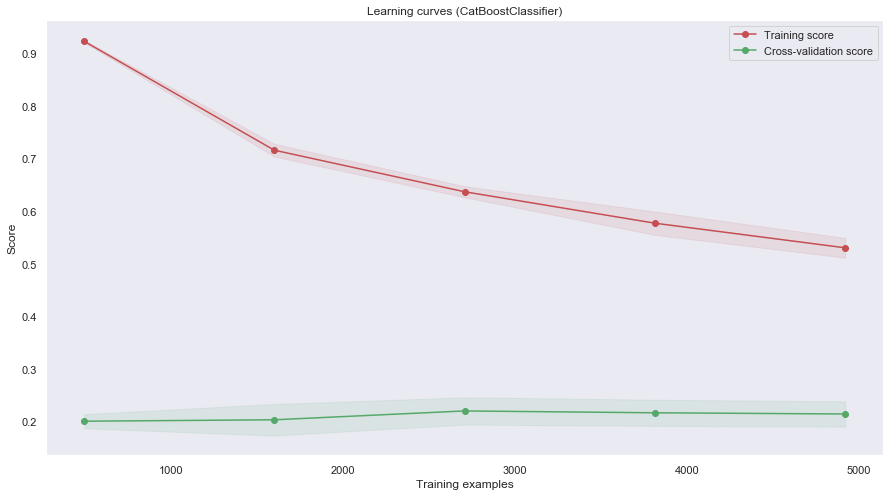

In [82]:
show_learning_curve_plot(final_model, X, y)

### –í—ã–±–æ—Ä –ø–æ—Ä–æ–≥–∞ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∫–ª–∞—Å—Å–∞

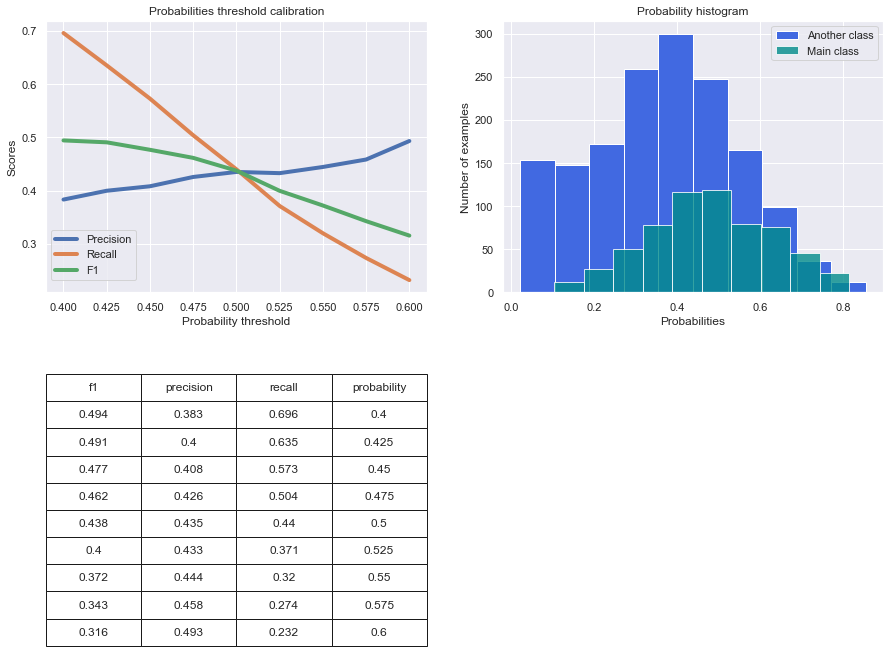

In [83]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

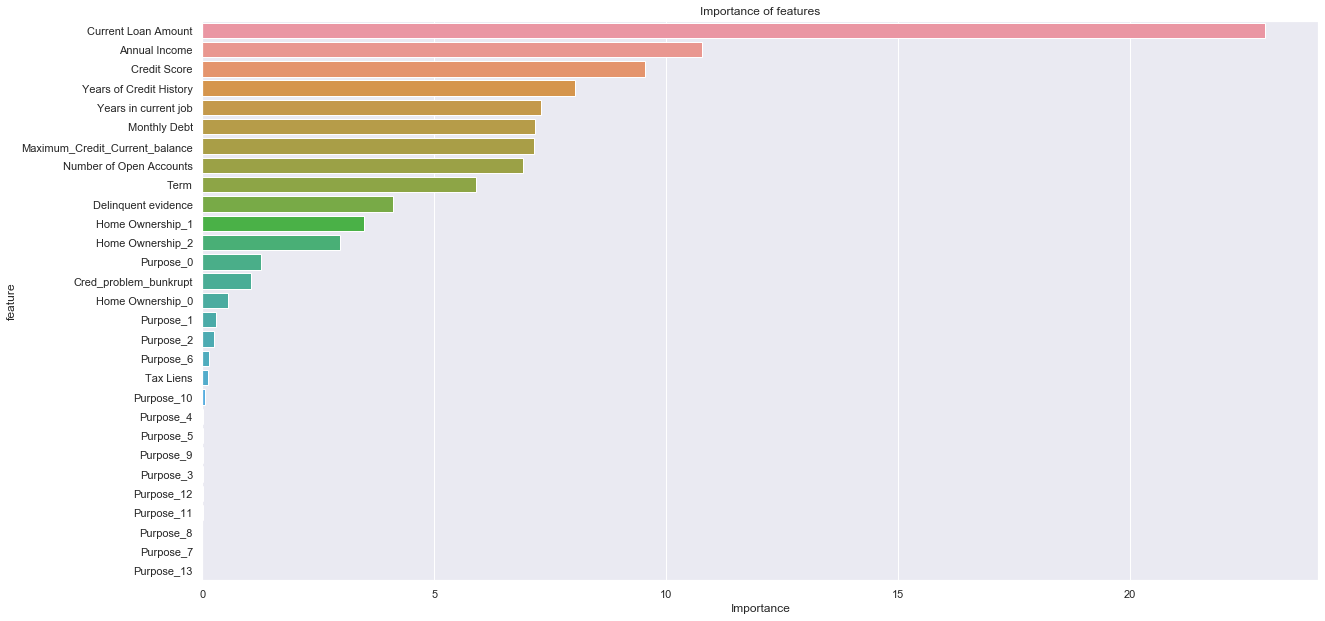

In [84]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

–ü–æ–¥—Å—Ç–∞–Ω–æ–≤–∫–∞ "–≤–∞–∂–Ω—ã—Ö" –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –Ω–µ —É–ª—É—á—à–∏–ª–∞ –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏

### –û–±—É—á–µ–Ω–∏–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª–∏

In [87]:
final_model.fit(X, y)

### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

In [117]:
# dt_scale.describe().T.round()

In [118]:
X_pred = dt_scale

In [119]:
y_pred = final_model.predict(X_pred)

In [120]:
y_pred=pd.DataFrame(y_pred,columns=['Credit Default'])

In [121]:
y_pred.to_csv(FINAL_PATH,index=False, encoding='utf-8')